In [1]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import time_ns

from gym_atom_array.env import ArrayEnv, Config

## Specify exp name and model version

In [2]:
wandb_name = "run-20230303_160745-fzu6hvtx"
model_version = "final"

model_path = f"wandb/{wandb_name}/files/agent-{model_version}.pt"

## Configure environment and load model

In [3]:
from argparse import Namespace
from clean_agents.ppo import make_env
from clean_agents.networks import SeparateNets as Agent

args = Namespace(Render=False, TargetSize=4, ArraySize=6, DefaultPenalty=-0.1, TargetPickUp=-5, TargetRelease=10, TimeLimit=200)
envs = gym.vector.SyncVectorEnv(
    [make_env(1, args),]
)
device = torch.device("cpu")

In [4]:
agent = Agent(envs, device)
state_dict = torch.load(model_path)
agent.load_state_dict(state_dict)

agent.eval()

SeparateNets(
  (extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=512, out_features=64, bias=True)
    (6): ReLU()
  )
  (critic): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=512, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=64, bias=True)
    (8): Tanh()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): Tanh()
    (11): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_si

# Comparison

In [12]:
def eval_agent(rl_agent, next_obs):
    next_obs = torch.Tensor(next_obs)

    start = time_ns()
    num_moves, moves_length = 0, 0
    with torch.no_grad():
        holding = False
        
        i = 0
        done = False
        while not done and i < args.TimeLimit:
            action, logprob, _, _ = rl_agent.get_action_and_value(next_obs)
            action = action.cpu().numpy()

            next_obs, reward, done, info = envs.step(action)
            next_obs = torch.Tensor(next_obs)
            i += 1
            
            act = action[0]
            if holding and act == 5:
                holding = False
                num_moves += 1                
            
            if holding:
                moves_length += 1
    
            if not holding and act == 4:
                holding = True
    end = time_ns()
    
    if not done:
        print("Timed out")
    return num_moves, moves_length, (end - start)

In [13]:
from classic_algos.LSAP import LSAPPlanner
from classic_algos.ASA import ASAPlanner

def get_total_len(moves):
    s = 0
    for start, end in moves:
        s += abs(start[0] - end[0]) + abs(start[1] - end[1])
    return s

In [26]:
num_moves = [[], [], []]
move_length = [[], [], []]
times = [[], [], []]
names = ["LSAP", "ASA", "RL"]

In [27]:
N_ITERS = 50
for _ in range(N_ITERS):
    next_obs = envs.reset()
#     envs.envs[0].render()

    n_size = envs.single_observation_space.shape[1]
    atom_grid, tar_grid, _ = next_obs[0]

    atoms, targets = [], []
    for r in range(n_size):
        for c in range(n_size):
            if atom_grid[r][c] == 1:
                atoms.append((r, c))
            if tar_grid[r][c] == 1:
                targets.append((r, c))

    lsap_agent = LSAPPlanner(n_size, n_size, targets, "cityblock")
    moves_, num_ = lsap_agent.get_moves(atoms)
    len_ = get_total_len(moves_)
    num_moves[0].append(num_)
    move_length[0].append(len_)

    asa_agent = ASAPlanner(n_size, n_size, targets)
    moves_, num_ = asa_agent.get_moves(atoms)
    len_ = get_total_len(moves_)
    num_moves[1].append(num_)
    move_length[1].append(len_)

    num_, len_, time_ = eval_agent(agent, next_obs)
    num_moves[2].append(num_)
    move_length[2].append(len_)
    times[2].append(time_)

Text(0.5, 1.0, 'Average length of moves over 50 runs')

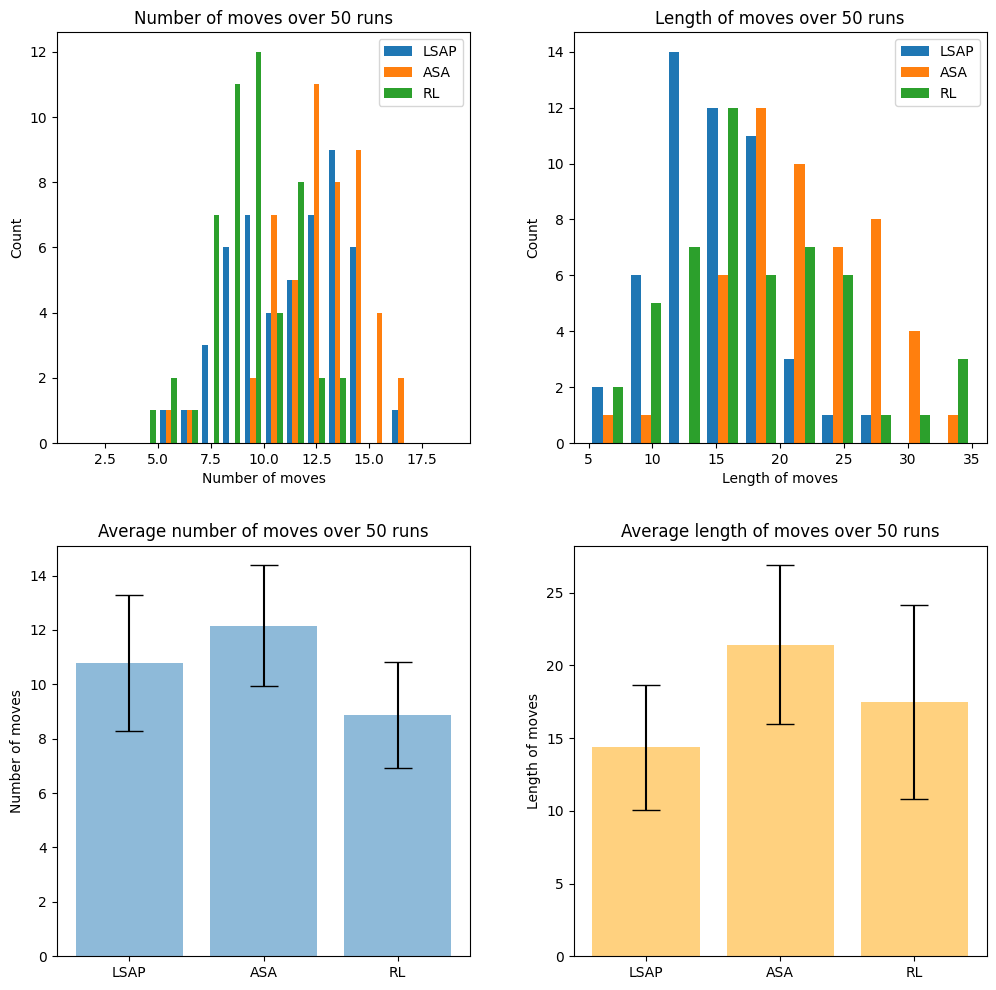

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw=dict(wspace=0.25, hspace=0.25))

# fig.set_title("Stats for 4x4 target in 6x6 array")

ax1.hist(num_moves, bins=range(1, 20), histtype="bar")
ax1.legend(names)
ax1.set_xlabel("Number of moves")
ax1.set_ylabel("Count")
ax1.set_title(f"Number of moves over {N_ITERS} runs")

ax2.hist(move_length, histtype="bar")
ax2.legend(names)
ax2.set_xlabel("Length of moves")
ax2.set_ylabel("Count")
ax2.set_title(f"Length of moves over {N_ITERS} runs")

num_moves = np.array(num_moves)
move_means = np.mean(num_moves, axis=1)
move_errs = np.std(num_moves, axis=1)

ax3.bar((0, 1, 2), move_means, yerr=move_errs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax3.set_xticks((0, 1, 2))
ax3.set_xticklabels(names)
ax3.set_ylabel("Number of moves")
ax3.set_title(f"Average number of moves over {N_ITERS} runs")

move_length = np.array(move_length)
length_means = np.mean(move_length, axis=1)
length_errs = np.std(move_length, axis=1)

ax4.bar((0, 1, 2), length_means, yerr=length_errs, align='center', alpha=0.5, color='orange', ecolor='black', capsize=10)
ax4.set_xticks((0, 1, 2))
ax4.set_xticklabels(names)
ax4.set_ylabel("Length of moves")
ax4.set_title(f"Average length of moves over {N_ITERS} runs")

In [29]:
rl_times = np.array(times[2])
rl_times.mean() // 1e6, rl_times.std() // 1e6

(29.0, 8.0)

## Masking testing

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [120]:
obs1 = torch.tensor([[[0,1,1,1,1],[0,1,1,1,0],[1,0,1,0,1],[0,1,1,0,0],[1,0,1,1,0]],[[0,0,0,0,0],[0,1,1,1,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,1],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]])
obs2 = torch.tensor([[[0,1,1,1,1],[0,1,1,1,1],[1,0,1,0,1],[0,1,1,0,0],[1,0,1,1,0]],[[0,0,0,0,0],[0,1,1,1,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,2],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]])

batch = torch.tensor((obs1.numpy(), obs2.numpy()))

In [121]:
kernel = torch.tensor([[[[0, 1000, 0],[10, 10000, 1],[0, 100, 0]],  [[0, 0, 0],[0, 0, 0],[0, 0, 0]],  [[0, 0, 0],[0, 100000, 0],[0, 0, 0]]]])


In [122]:
has_atoms = torch.amax(batch, (1, 2, 3))

padded = F.pad(batch, (1,)*4, value=2)
detect = F.conv2d(padded, kernel)
inter_masks = torch.amax(detect, (1, 2, 3))

inter_masks = inter_masks + inter_masks * (has_atoms == 2)
masks_ = torch.column_stack((
    inter_masks % 10000 < 2000,
    inter_masks % 1000 < 200,
    inter_masks % 100 < 20,
    inter_masks % 10 < 2,
    torch.logical_and(has_atoms == 1, inter_masks % 100000 >= 10000),
    has_atoms == 2
))

In [123]:
masks_

tensor([[ True,  True,  True, False, False, False],
        [False, False, False, False, False,  True]])

In [124]:
obs1

tensor([[[0, 1, 1, 1, 1],
         [0, 1, 1, 1, 0],
         [1, 0, 1, 0, 1],
         [0, 1, 1, 0, 0],
         [1, 0, 1, 1, 0]],

        [[0, 0, 0, 0, 0],
         [0, 1, 1, 1, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]])

In [125]:
inter_masks

tensor([101112, 422224])

In [119]:
inter_masks

tensor([111112, 422224])

In [100]:
has_atoms

tensor([1, 2])

In [60]:
torch.amax(obs, 2)

tensor([[1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]])

In [77]:
batch = torch.tensor((obs.numpy(), obs.numpy()*2))
has_atom = torch.amax(batch, (1, 2, 3))
has_atom == 1, has_atom == 2

(tensor([ True, False]), tensor([False,  True]))

In [111]:
batch.shape

torch.Size([2, 3, 5, 5])